In [ ]:
!pip install pykep
!pip install pygmo

import pykep as pk
import pygmo as pg
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Константы
AU = 149597870700 #[м]
MU_SUN = 1.32712440042e20 #[м^3/с^2]
EARTH_VELOCITY = 11.186e3 #[м/с]
G0 = 9.80665 #[м/с^2]

In [3]:
# Принцип максимума 

from pykep.core import epoch
#epoch - Возвращает юлианскую дату(формат J200)
from pykep.core import MU_SUN, EARTH_VELOCITY, G0, AU
from scipy.integrate import ode
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from pykep.sims_flanagan import spacecraft

class _dynamics(object):

    def __init__(self, sc=spacecraft(1000, 0.3, 2500), mu=MU_SUN, alpha=1, bound=True):

        self.spacecraft = sc

        # Гравитирующий центр
        self.mu = float(mu)

        self.bound = bool(bound)

        # Параметры двигателя
        self.c1 = self.spacecraft.thrust # тяга двигателя
        self.c2 = self.spacecraft.thrust / (self.spacecraft.isp * G0)  #расход топлива

        # Перейдем к безразмерным параметрам
        self.L = AU 
        self.V = EARTH_VELOCITY
        self.M = self.spacecraft.mass
        self.A = (self.V * self.V) / self.L  #ускорение
        self.F = self.M * self.A #сила
        self.T = self.L / self.V #период
        self.Q = self.F / self.V #мощность

        # обезразмерим параметры двигателя
        self.c1 /= self.F
        self.c2 /= self.Q
        self.mu /= MU_SUN

    def _rhs_fullstate(self, fullstate): #Уравнение правой части

        x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lvm, obj = fullstate #вектор полного состояния
        u, ix, iy, iz = self._pontryagin(fullstate) # здесь даны модуль и  вектор управляющей тяги 

        imp = self.c1 * u / m #удельный импульс
        r = (x**2 + y**2 + z**2)**(1 / 2)

        x0 = self.c1 * u / m
        x1 = x**2
        x2 = y**2
        x3 = z**2
        x4 = x1 + x2 + x3
        x5 = self.mu / x4**(3 / 2)
        x6 = x4**(-5 / 2)
        x7 = 3 * lvy * self.mu * x6 * y
        x8 = 3 * lvz * self.mu * x6 * z
        x9 = -x5
        x10 = 3 * self.mu * x6
        x11 = 3 * lvx * self.mu * x * x6
        x12 = self.c1 * u / m**2

        # выражения правой части
        rfs = np.array([
            vx,
            vy,
            vz,
            ix * x0 - x * x5,
            iy * x0 - x5 * y,
            iz * x0 - x5 * z,
            -self.c2 * u,
            -lvx * (x1 * x10 + x9) - x * x7 - x * x8,
            -lvy * (x10 * x2 + x9) - x11 * y - x8 * y,
            -lvz * (x10 * x3 + x9) - x11 * z - x7 * z,
            -lx,
            -ly,
            -lz,
            ix * lvx * x12 + iy * lvy * x12 + iz * lvz * x12,
            u**2
        ])

        return rfs

    def _hamiltonian(self, fullstate):

        x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lm, obj = fullstate
        u, ix, iy, iz = self._pontryagin(fullstate)

        imp = self.c1 * u / m 
        mu_r_3 = self.mu / (x**2 + y**2 + z**2)**(3 / 2) 

        # Гамильтонин
        H = -lm * self.c2 * u + lx * vx + ly * vy + lz * vz + lvx * (ix * imp - x * mu_r_3) + lvy * (
            iy * imp - mu_r_3 * y) + lvz * (iz * imp - mu_r_3 * z) + u**2

        return H

    def _pontryagin(self, fullstate):

        x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lm, obj = fullstate

        lv = (lvx**2 + lvy**2 + lvz**2)**0.5

        u = (self.c1 * lv + m * self.c2 * lm) /(2 * m)

        # Ограничение управляющей тяги
        if self.bound:
            u = max(u, 0.0)
            u = min(u, 1.0)

        elif not self.bound:
            pass

        # Направление управления
        ix = -lvx / lv
        iy = -lvy / lv
        iz = -lvz / lv

        # Вектор контрольного воздействия
        control = np.array([u, ix, iy, iz])

        return control

class pontryagin_leg(object):
    """
    Атрибуты:
        - t0 (``float``): Время отправления [mjd2000].
        - x0 (``numpy.ndarray``): Начальный вектор состояния КА [m, m, m, m/s, m/s, m/s, kg].
        - l0 (``numpy.ndarray``): Переменные затрат [ND, ND, ND, ND, ND, ND, ND].
        - tf (``float``): Время прибытия [mjd2000].
        - xf (``numpy.ndarray``): Вектор состояния КА в момент прибытия [m, m, m, m/s, m/s, m/s, kg].
        - sc (): Объект КА 
        - mu (``float``): Гравитационный параметр главного гравитирующего центра (Солнце) [m^3/s^2].
        - bound (``bool``): Индикатор граничных условий.
        - trajectory (``numpy.ndarray``): Массив векторов состояний траектории.
        - times (``numpy.ndarray``): Массив узлов интегрирования
    """

    def __init__(self, t0=None, x0=None, l0=None, tf=None, xf=None, sc=spacecraft(1000, 0.3, 2500), mu=MU_SUN, alpha=1, bound=True):

        self.spacecraft = sc
        self.mu = float(mu)

        # Прикрепление динамики
        self._dynamics = _dynamics(
            sc=self.spacecraft, mu=mu, alpha=alpha, bound=bound)

        self.bound = bool(bound)
      
        self.nec = 8
        self.alpha = float(alpha)

        if any(elem is None for elem in [t0, x0, l0, tf, xf]):
            pass

        # Проверка граничных условий
        else:

            # check departure and arrival times
            if not all([isinstance(t, epoch) for t in [t0, tf]]):
                raise TypeError(
                    "Departure and arrival times, t0 & tf, must be supplied as pykep.epoch.")
            elif not t0.mjd2000 < tf.mjd2000:
                raise ValueError(
                    "Departure time must occur before arrival time.")
            else:
                self.t0 = float(t0.mjd2000)
                self.tf = float(tf.mjd2000)

            # check departure and arrival states
            states = [x0, xf]
            if not all([isinstance(state, sc_state) for state in states]):
                raise TypeError(
                    "x0 and xf must be instances of pykep.sims_flanagan.sc_state.")
            else:
                self.x0 = np.asarray(x0.get(), np.float64)
                self.xf = np.asarray(xf.get(), np.float64)

            # check departure costate
            if not (isinstance(l0, list) or isinstance(l0, np.ndarray) or isinstance(l0, tuple)):
                raise TypeError(
                    "Departure costate, l0, must be supplied as either a list, numpy.ndarray, or tuple.")
            elif len(l0) != 7:
                raise TypeError("Costate vector, l0, must be 7-dimensional.")
            else:
                self.l0 = np.asarray(l0, np.float64)

        # integrator
        self._integrator = ode(
            lambda t, fs: self._dynamics._rhs_fullstate(fs),
        )

    def _recorder(self, t, fs): # запись интегрирования для отладки

        self.times = np.append(self.times, t)

        self.trajectory = np.vstack((self.trajectory, fs))

    def set(self, t0, x0, l0, tf, xf): # Задаем граничные условия вылета и посадки
        # Отправление
        self.t0 = float(t0.mjd2000)
        self.x0 = np.asarray(x0.get(), np.float64)
        self.l0 = np.asarray(l0, np.float64)

        # Прибытие
        self.tf = float(tf.mjd2000)
        self.xf = np.asarray(xf.get(), np.float64)


    def _propagate(self, atol, rtol): #Интегратор

        # Оберзразмеривание параметров
        x0 = np.copy(self.x0)
        x0[0:3] /= self._dynamics.L
        x0[3:6] /= self._dynamics.V
        x0[6] /= self._dynamics.M

        fs0 = np.hstack((x0, self.l0, [0]))

        t0 = self.t0 * 24 * 60 * 60
        tf = self.tf * 24 * 60 * 60
        # Перевод к секунды
        t0 /= self._dynamics.T
        tf /= self._dynamics.T

        self.times = np.empty((1, 0), dtype=np.float64)
        self.trajectory = np.empty((0, 15), dtype=np.float64)

        # Можно использовать и метод lsoda
        self._integrator.set_integrator("dop853", atol=atol, rtol=rtol)

        # Запись интегрирования
        self._integrator.set_solout(self._recorder)

        # Начальные условия
        self._integrator.set_initial_value(fs0, t0)

        self._integrator.integrate(tf)

    def mismatch_constraints(self, atol=1e-8, rtol=1e-8): #Вычисление несоответсвий между динамикой и требуемым состоянием
      
        atol = float(atol)
        rtol = float(atol)

        self._propagate(atol, rtol)

        # Требуемые безразмерные условия прибытия
        brf = self.xf[0:3] / self._dynamics.L
        bvf = self.xf[3:6] / self._dynamics.V

        rf = self.trajectory[-1, 0:3]
        vf = self.trajectory[-1, 3:6]

        # Вычисление невязки
        drf = rf - brf
        dvf = (vf - bvf)

        # масса по прибытии
        lmf = self.trajectory[-1, 13]

        #Гамильтониан по прибытии
        Hf = self._dynamics._hamiltonian(self.trajectory[-1])

        # Для проверки
        ceq = np.hstack((drf, dvf, [lmf], [Hf]))

        return ceq

    def get_states(self, atol=1e-12, rtol=1e-12): 

        atol = float(atol)
        rtol = float(atol)

        self._propagate(atol, rtol)

        # nondimensional times
        t = np.copy(self.times)

        # mjs2000
        t *= self._dynamics.T
        t /= 24 * 60 * 60
        t = t.reshape(t.size, 1)

        # Управление
        u = np.asarray([self._dynamics._pontryagin(fs)
                        for fs in self.trajectory])

        #Гамильтониан
        H = np.asarray([self._dynamics._hamiltonian(fs)
                        for fs in self.trajectory])
        H = H.reshape(H.size, 1)

        traj = np.copy(self.trajectory)
        traj[:, 0:3] *= self._dynamics.L
        traj[:, 3:6] *= self._dynamics.V
        traj[:,   6] *= self._dynamics.M

        # Возвращаем вектор состояний траектории с управлением и гамильтонианами
        traj = np.hstack((t, traj, u, H))

        return traj

    def plot_traj(self, axes, mark="k", atol=1e-11, rtol=1e-11, units=AU, quiver=False, length=1):
        #Plots trajectory onto a 3D axis.

        # get trajectory
        full_data = self.get_states(atol=atol, rtol=rtol)
        traj = full_data[:, 1:4]

        # normalise
        traj /= units

        # plot trajectory
        axes.plot(traj[:, 0], traj[:, 1], traj[:, 2], mark)

        if quiver:
            thrusts = full_data[:, 17:20]
            magnitudes = full_data[:, 16]
            thrusts[:, 0] = thrusts[:, 0] * magnitudes
            thrusts[:, 1] = thrusts[:, 1] * magnitudes
            thrusts[:, 2] = thrusts[:, 2] * magnitudes

            axes.set_aspect("equal")
            xlim = axes.get_xlim()
            zlim = axes.get_zlim()
            ratio = (xlim[1] - xlim[0]) / (zlim[1] - zlim[0])
            # to compensate for non equal z axes
            thrusts[:, 2] = thrusts[:, 2] / ratio

            axes.quiver(traj[:, 0], traj[:, 1], traj[:, 2], thrusts[:, 0], thrusts[:, 1], thrusts[
                        :, 2], color='r', length=length, normalize=False, arrow_length_ratio=0.00, alpha=0.6)

        return axes

    def plot(self, x, y, mark="k.-", atol=1e-12, rtol=1e-12, unitsx=1, unitsy=1, xlabel=False, ylabel=False, axes=None):

        keys = ['tof', 't', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'm', 'lx', 'ly',
                'lz', 'lvx', 'lvy', 'lvz', 'lm', 'obj', 'u', 'ux', 'uy', 'uz', 'H']

        # get trajectory
        traj = self.get_states(atol=atol, rtol=rtol)

        # append tof
        tof = traj[:, 0]
        tof = tof - tof[0]
        traj = np.hstack((tof.reshape(tof.size, 1), traj))
        # get components and normalise
        xi, yi = keys.index(x), keys.index(y)

        # create figure
        if axes is None:
            fig = plt.figure()
            axes = fig.gca()

        # plot
        axes.plot(traj[:, xi] / unitsx, traj[:, yi] / unitsy, mark)

        # labels
        if isinstance(xlabel, str):
            plt.xlabel(xlabel)
        elif xlabel is True:
            plt.xlabel(x)

        if isinstance(ylabel, str):
            plt.ylabel(ylabel)
        elif ylabel is True:
             plt.ylabel(y)

        return axes
        

In [31]:
class _indirect_base(object):
    #Base class for indirect trajectory optimisation problems. 


    def __init__(
        self, mass, thrust, isp,
        mu, alpha, bound,
        atol, rtol
    ):

        self.sc = pk.sims_flanagan.spacecraft(mass, thrust, isp)
        
        self.leg = pontryagin_leg(sc=self.sc, alpha=alpha, mu=mu, bound=bound)

        # Параметры интегрирование
        self.atol = float(atol)
        self.rtol = float(rtol)

    def fitness(self, z):
        pass

    def _plot_traj(self, z, axes, units):
        pass

    def _output(self, z):
        pass

    def get_nobj(self):
        return 1

    def plot_traj(self, z, mark="k", atol=1e-12, rtol=1e-12, units=AU, axes=None, quiver=False, length=1):

        self.fitness(z)

        # figure
        if axes is None:
            fig = plt.figure()
            axes = fig.gca(projection='3d')
        elif not isinstance(axes, Axes3D):
            raise TypeError(
                "Axis must be instance of matplotlib.axes._subplots.Axes3DSubplot.")

        self._plot_traj(z, axes, units)

        # Солнце
        axes.scatter([0], [0], [0], color='y')

        # Траектория
        self.leg.plot_traj(axes, mark, atol, rtol, units,
                           quiver=quiver, length=length)

        return axes

    def plot_control(self, z, mark="k.-", atol=1e-12, rtol=1e-12, axes=None):

        self.fitness(z)

        if axes is None:
            fig = plt.figure()
            axes = fig.gca()

        # leg
        self.leg.plot('tof', 'u', mark=mark, atol=atol, rtol=rtol,
                      xlabel="Время [mjd2000]", ylabel="Импульсы [ND]", axes=axes)

        return axes

    def get_traj(self, z):

        self.fitness(z)

        x = self.leg.get_states()

        # переход к размерным величинам
        for t in x:
            t[-4] *= t[-5]
            t[-3] *= t[-5]
            t[-2] *= t[-5]
        return x

    def output(self, z):
        data = self.get_traj(z)
        self._output(z)

        print("\nНачальное положение КА (m)  : [{!r}, {!r}, {!r}]".format(
            data[0, 1], data[0, 2], data[0, 3]))
        print("Начальная скорость КА (m/s)  : [{!r}, {!r}, {!r}]".format(
            data[0, 4], data[0, 5], data[0, 6]))
        print("Начальная масса КА (kг)      : {!r}".format(data[0, 7]))

        print("Конечная позиция КА (m)  : [{!r}, {!r}, {!r}]".format(
            data[-1, 1], data[-1, 2], data[-1, 3]))
        print("Конечная скорость КА (m/s): [{!r}, {!r}, {!r}]".format(
            data[-1, 4], data[-1, 5], data[-1, 6]))
        print("Конечная масса  (kг)    : {!r}".format(data[-1, 7]))
        print("Использовано топлива  (kг)          : {!r}".format(
            data[0, 7] - data[-1, 7]))

class indirect_or2or(_indirect_base): # Траектория между двумя орбитами 
    def __init__(self,
                 elem0=[149598261129.93335, 0.016711230601231957,
                        2.640492490927786e-07, 3.141592653589793, 4.938194050401601, 0],
                 elemf=[227943822376.03537, 0.09339409892101332,
                        0.032283207367640024, 0.8649771996521327, 5.000312830124232, 0],
                 mass=1000,
                 thrust=0.3,
                 isp=2500,
                 alpha=0,
                 atol=1e-12,
                 rtol=1e-12,
                 tof=[100, 700],
                 bound=False,
                 mu=pk.MU_SUN):

        _indirect_base.__init__(
            self, mass, thrust, isp, mu, alpha, bound, atol, rtol)

        # Кеплеровские орбиты элементов 
        self.elem0 = np.asarray(elem0)
        self.elemf = np.asarray(elemf)

        # Ограничение на время полета
        self.tof = tof

    def fitness(self, z):

        t0 = pk.epoch(0)
        tf = pk.epoch(z[0])

        # Эксцентрические аномалии начала и конца полета
        M0 = z[1]
        Mf = z[2]

        # Затраты при прибытии
        l0 = np.asarray(z[3:])

        elem0 = np.hstack([self.elem0[:5], [M0]])
        elemf = np.hstack([self.elemf[:5], [Mf]])

        # Определяем из кеплеровских элементов векторы состояния в граничные моменты
        r0, v0 = pk.par2ic(elem0, self.leg.mu)
        rf, vf = pk.par2ic(elemf, self.leg.mu)

        x0 = pk.sims_flanagan.sc_state(r0, v0, self.sc.mass)
        xf = pk.sims_flanagan.sc_state(rf, vf, self.sc.mass / 10)

        self.leg.set(t0, x0, l0, tf, xf)

        ceq = self.leg.mismatch_constraints(atol=self.atol, rtol=self.rtol)

        # Масса по прибытии
        obj = self.leg.trajectory[-1, -1]

        # Трансверсальные условия
        # В начале
        lambdas0 = np.array(self.leg.trajectory[0, 7:13])
        r0norm = np.sqrt(r0[0] * r0[0] + r0[1] * r0[1] + r0[2] * r0[2])
        tmp = - MU_SUN / r0norm**3
        tangent = np.array([v0[0], v0[1], v0[2], tmp *
                            r0[0], tmp * r0[1], tmp * r0[2]])
        tangent_norm = np.linalg.norm(tangent)
        tangent = tangent / tangent_norm
        T0 = np.dot(lambdas0, tangent)

        # В конце
        lambdasf = np.array(self.leg.trajectory[-1, 7:13])
        rfnorm = np.sqrt(rf[0] * rf[0] + rf[1] * rf[1] + rf[2] * rf[2])
        tmp = - MU_SUN / rfnorm**3
        tangent = np.array([vf[0], vf[1], vf[2], tmp *
                            rf[0], tmp * rf[1], tmp * rf[2]])
        tangent_norm = np.linalg.norm(tangent)
        tangent = tangent / tangent_norm
        Tf = np.dot(lambdasf, tangent)

        return np.hstack(([1], ceq, [T0, Tf]))

    def get_nec(self):
        return self.leg.nec + 2

    def get_bounds(self):
        lb = [self.tof[0], -4 * np.pi, -4 * np.pi] + [-1e2] * 7
        ub = [self.tof[1], 4 * np.pi, 4 * np.pi] + [1e2] * 7
        return (lb, ub)

    def _plot_traj(self, z, axes, units):
        t0 = pk.epoch(0)
        tf = pk.epoch(z[0])

        
        M0 = z[1] - self.elem0[1] * np.sin(z[1])
        Mf = z[2] - self.elemf[1] * np.sin(z[2])

        elem0 = np.hstack([self.elem0[:5], [M0]])
        elemf = np.hstack([self.elemf[:5], [Mf]])

        kep0 = pk.planet.keplerian(t0, elem0)
        kepf = pk.planet.keplerian(tf, elemf)

        pk.orbit_plots.plot_planet(
            kep0, t0=t0, units=units, axes=axes, color=(0.8, 0.8, 0.8))
        pk.orbit_plots.plot_planet(
            kepf, t0=tf, units=units, axes=axes, color=(0.8, 0.8, 0.8))

    def _output(self, z):
        print("\nТрансфер между орбитами: ")
        print("\nНачальная орбита: " + str(list(self.elem0)))
        print("Орбита назначения: " + str(list(self.elemf)))
        print("Время полета (суток): {!r} ".format(z[0]))
        print("Начальная аномалия (rad): {!r} ".format(z[1]))
        print("Аномалия по прибытии (rad): {!r} ".format(z[2]))


In [65]:
#Некоторые начальные оптимальные решения
z_quadratic_control = [381.32031472240106, 1.0102363292172423, 1.8134352964367946, 19.522442569527868, -6.7894353762521105, -3.3749783899165928, 7.0438655057343054, 19.923912672512174, 0.93896446800741751, 3.5483645070393743]
z_quadratic_control2 = [459.51623108767666, -1.616057488705803, 0.33049652475302532, -17.735981532357027, - 3.2374905349904912, 2.2249621531880934, 2.9550456430212937, -20.226761256676323, -2.9684113654904061, 3.1471248891703905]
z_quadratic_control3 = [519.45371103815569, 0.39617485433378341, 2.7008977766929818, 7.9136210333255468, -11.03747486077437, -3.0776988186969136, 9.1796869310249747, 6.5013311040515687, -0.2054349910826633, 3.0084671211666865]
    
#Можно использовать это начальное предположение (находится в пределах 10% от оптимального)
z = z_quadratic_control3

# Случайное начальное предположение
#z = np.hstack([[np.random.uniform(100, 700)], 2 * np.random.randn(9)])

Используется алгоритм ipopt. Задача оптимизации, связанная с неравенством, решается путем преобразования ее в неограниченную целевую функцию, минимум которой ищем. Далее с помощью метода Ньютона и вычисления градиента находится требуемый оптимум.



In [66]:

def algo_factory(name='ipopt'): 
      uda = pg.ipopt() 
      uda.set_integer_option("print_level", 5)
      uda.set_integer_option("acceptable_iter", 4)
      uda.set_integer_option("max_iter", 150)

      uda.set_numeric_option("tol", 1e-8)
      uda.set_numeric_option("dual_inf_tol", 1e-8)
      uda.set_numeric_option("constr_viol_tol", 1e-8)
      uda.set_numeric_option("compl_inf_tol", 1e-8)

      uda.set_numeric_option("acceptable_tol", 1e-3)
      uda.set_numeric_option("acceptable_dual_inf_tol", 1e-2)
      uda.set_numeric_option("acceptable_constr_viol_tol", 1e-6)
      uda.set_numeric_option("acceptable_compl_inf_tol", 1e-6)

      algo = pg.algorithm(uda)
      return algo

algo = algo_factory()

Рассматривается решение с помощью квадратичного контролирующего воздействия со свободным временем (не фиксируется дата прилета)

In [67]:
# 2 - Задача 

class add_gradient:

    def __init__(self, udp, with_grad=False):
        self.udp_inner = udp
        self.prob = pg.problem(udp)
        self.with_grad = with_grad

    def fitness(self, x):
        return self.prob.fitness(x)

    def get_bounds(self):
        return self.prob.get_bounds()

    def get_nec(self):
        return self.prob.get_nec()

    def get_nic(self):
        return self.prob.get_nic()

    def get_nobj(self):
        return self.prob.get_nobj()

    def gradient(self, x):
        return pg.estimate_gradient(lambda x: self.fitness(x), x, 1e-8)

    def has_gradient(self):
        return self.with_grad

udp = add_gradient(indirect_or2or(
    elem0=[149598261129.93335, 0.016711230601231957,
               2.640492490927786e-07, 3.141592653589793, 4.938194050401601, 0],
    elemf=[227943822376.03537, 0.09339409892101332,
               0.032283207367640024, 0.8649771996521327, 5.000312830124232, 0],
    mass=1000,
    thrust=0.3,
    isp=2500,
    atol=1e-12,
    rtol=1e-12,
    tof=[100, 700],
    alpha = 0,
    bound=True,
    mu = MU_SUN),
    with_grad=True)

prob = pg.problem(udp)
prob.c_tol = [1e-7]*10


In [68]:
# 3 - Начальное предположение 
pop = pg.population(prob)
pop.push_back(z)

In [69]:
# 4 - Решим на основе начального предположения 
pop = algo.evolve(pop)

In [70]:
# 5 - Проверим наличие решения (найден ли оптимальный по расходу путь)
if prob.feasibility_x(pop.champion_x):
    print("Оптимум найден")

    udp.udp_inner.fitness(pop.champion_x)
    arr = udp.udp_inner.leg.get_states(1e-12, 1e-12)
    print("Конечная масса is: ", arr[-1, 7])
else:
    print("Не найден")

Оптимум найден
Конечная масса is:  788.4701102567544


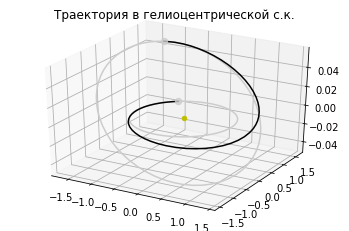

In [71]:
axis = udp.udp_inner.plot_traj(pop.champion_x, quiver=False, mark="k", length=1)
plt.title("Траектория в гелиоцентрической с.к.")
plt.ion()
plt.show()

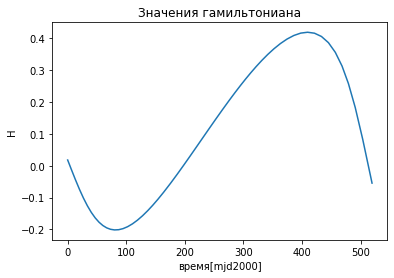

In [72]:
udp.udp_inner.fitness(pop.champion_x)
traj = udp.udp_inner.leg.get_states(1e-12, 1e-12)
t = traj[:, 0] # узлы времени
r = traj[:, 1:4] 
v = traj[:, 4:7] 
m = traj[:, 7] 
lm = traj[:, 14] # затраты массы 
u = traj[:, 15] # контрольные импульсы
H = traj[:, 19] # гамильтонианы

plt.plot(t, H)
plt.title("Значения гамильтониана")
plt.xlabel('время[mjd2000]')
plt.ylabel('H')
plt.show()

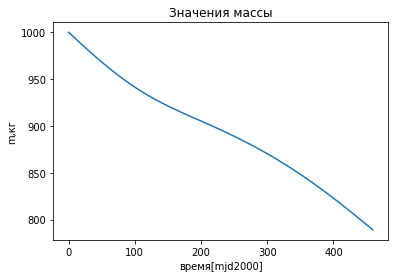

In [55]:
plt.plot(t, m)
plt.title("Значения массы")
plt.xlabel('время[mjd2000]')
plt.ylabel('m,кг')
plt.show()

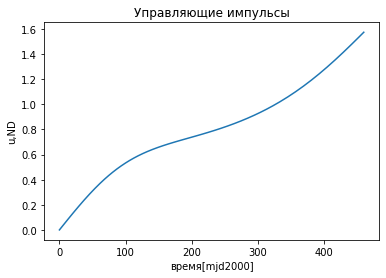

In [56]:
plt.plot(t, u)
plt.title("Управляющие импульсы")
plt.xlabel('время[mjd2000]')
plt.ylabel('u,ND')
plt.show()

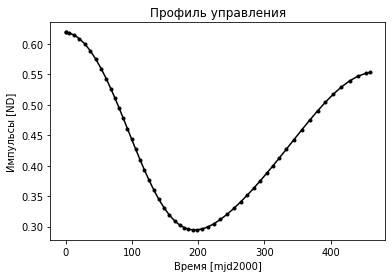

In [57]:

udp.udp_inner.plot_control(pop.champion_x)
plt.title("Профиль управления")
plt.ion()
plt.show()

In [58]:

udp.udp_inner.output(pop.champion_x)


Трансфер между орбитами: 

Начальная орбита: [149598261129.93335, 0.016711230601231957, 2.640492490927786e-07, 3.141592653589793, 4.938194050401601, 0.0]
Орбита назначения: [227943822376.03537, 0.09339409892101332, 0.032283207367640024, 0.8649771996521327, 5.000312830124232, 0.0]
Время полета (суток): 459.51623108767666 
Начальная аномалия (rad): -1.616057488705803 
Аномалия по прибытии (rad): 0.3304965247530253 

Начальное положение КА (m)  : [147706098765.29758, 24421382451.59738, -6448.447698152004]
Начальная скорость КА (m/s)  : [-5344.413741563389, 29278.358490867588, -0.007730928574182944]
Начальная масса КА (kг)      : 1000.0
Конечная позиция КА (m)  : [207420371281.41928, -11496513780.961063, -5338943592.934856]
Конечная скорость КА (m/s): [2271.926319552829, 26261.05083959784, 494.2761564819253]
Конечная масса  (kг)    : 788.9481142229839
Использовано топлива  (kг)          : 211.05188577701608
